## BI-PRS - Semestral Work 1 (samarrik's version)

### Code style & additional information (to be deleted)

**Headers:**
- # Work header
- ## The section, task
- ### Subtask

**Comments:**
- Major comments/descriptions are made in **markdown cells** with subtask definitions
- Smaller code-related comments are made directly in the code

**Images:**
- All images saved in the **./src/images** folder inside the project

**References:**
- References are made in text using [x], where **x** is a sequential number of a reference
- In the bottom of the notebook references are explained and specified using following template:

x. ***Source, Additional info, url***

### Country selection according to the representant's data

In [1]:
K <- 27
L <- nchar('bardatskii')
M <- ((K + L) * 47) %% 11 + 1

cat('Parameter M =', M, '=> Norsko, K.Dedecius')

Parameter M = 2 => Norsko, K.Dedecius

### Neccessary imports

In [2]:
.libPaths('~/stats/Rlib') # set up the path to your R library
#install.packages('...')   # install missing R packages

# Import relevant R packages
library(eurostat)
library(ggplot2)
library(gridExtra)
library(cowplot)
library(repr)
library(vtable)

Loading required package: kableExtra



## Dataset preparation

- Download the dataset
- Describe the columns
- Extract relevant data

In [3]:
# Downloading the dataset
dataset <- get_eurostat(id ='crim_gen_reg')

Table crim_gen_reg cached at /tmp/RtmpXmChTD/eurostat/a2939e209a7e6021da51fe52fa89a065.rds



In [4]:
# First glance at the data we've received
head(dataset, 2)

freq,unit,iccs,geo,TIME_PERIOD,values
<chr>,<chr>,<chr>,<chr>,<date>,<dbl>
A,NR,ICCS0101,AL,2008-01-01,88
A,NR,ICCS0101,AL,2009-01-01,82


#### Column description:

- **geo**: Geopolitical entity (reporting)
- **iccs**: International classification of crime for statistical purposes
- **time**: Time
- **freq**: Frequency
- **unit**: Unit of measure

[1]

#### Dataset completeness

There are no problems with the completeness of the data for the year 2021 from Norway.

[2]

![completeness](src/images/completeness.png)

#### Data units of measure explanation

We have multiple units of measure in this dataset. Let's clarify which ones we have here.

[3]

![units](src/images/units.png)

#### Relevant data selection
- Norway NUTS3 regions
- Records for the year 2021
- P_HTHAB (Per hundred thousand inhabitants) units*

\* - We will use relative units, not exact ones because relative units better show amount of crimes according to the number of people
living there

In [5]:
data <- dataset[startsWith(dataset$geo, 'NO') & (nchar(dataset$geo) == 5),]
data <- data[data$TIME_PERIOD == '2021-01-01',]
data.r <- data[data$unit == 'P_HTHAB',]
data.a <- data[data$unit == 'NR',]
data.a$unit <- NULL
data.r$unit <- NULL
data.a$freq <- NULL
data.r$freq <- NULL
data.a$TIME_PERIOD <- NULL
data.r$TIME_PERIOD <- NULL
head(data, 3)

freq,unit,iccs,geo,TIME_PERIOD,values
<chr>,<chr>,<chr>,<chr>,<date>,<dbl>
A,NR,ICCS0101,NO020,2021-01-01,0
A,NR,ICCS0101,NO060,2021-01-01,1
A,NR,ICCS0101,NO071,2021-01-01,0


#### Suitable column types transformations

- iccs - should be factor
- geo - should be factor

In [6]:
data.a$iccs <- as.factor(data.a$iccs)
data.a$geo <- as.factor(data.a$geo)
data.r$iccs <- as.factor(data.r$iccs)
data.r$geo <- as.factor(data.r$geo)

head(data.a, 3)

iccs,geo,values
<fct>,<fct>,<dbl>
ICCS0101,NO020,0
ICCS0101,NO060,1
ICCS0101,NO071,0


#### Rename factor categories

![iccs_codes](src/images/iccs_codes.png)

[4] 

**Not provided in the dataset**:
- Assault (ICCS02011)
- Burglary (ICCS0501)
- Burglary of private residential premises (ICCS05012)

[2]

In [7]:
prev_labels <- c('ICCS0101', 'ICCS0401', 'ICCS0502', 'ICCS050211')
new_labels <- c('Int. homicide', 'Robbery', 'Theft', 'Theft of a m. l. vehicle')
data.a$iccs <- factor(data.a$iccs, levels=prev_labels, labels = new_labels)
data.r$iccs <- factor(data.r$iccs, levels=prev_labels, labels = new_labels)
head(data, 3)

freq,unit,iccs,geo,TIME_PERIOD,values
<chr>,<chr>,<chr>,<chr>,<date>,<dbl>
A,NR,ICCS0101,NO020,2021-01-01,0
A,NR,ICCS0101,NO060,2021-01-01,1
A,NR,ICCS0101,NO071,2021-01-01,0


## Exploratory data analysis & descriptive statistics

The data we have represent a number of crimes of each specific type for each NUTS3 Norway region represented in P_HTHAB (Per hundred thousand inhabitants) units. To analyse the following data, statistical measures and graphs will be used. As a result, we want to get insights about the criminality in different NUTS3 regions of Norway.

**For each region separately:**

- The distribution of crime types in each region

**For all regions at once:**
- Descriptive statistics about each crime type ( selection ) Mean / max / min / quartiles
- The distribution of each crime type through all regions histogram & kde / boxplot / q-q plot

In [8]:
# Get all Norway NUTS3 region codes
norway_nuts3_regions <- unique(data.a$geo)

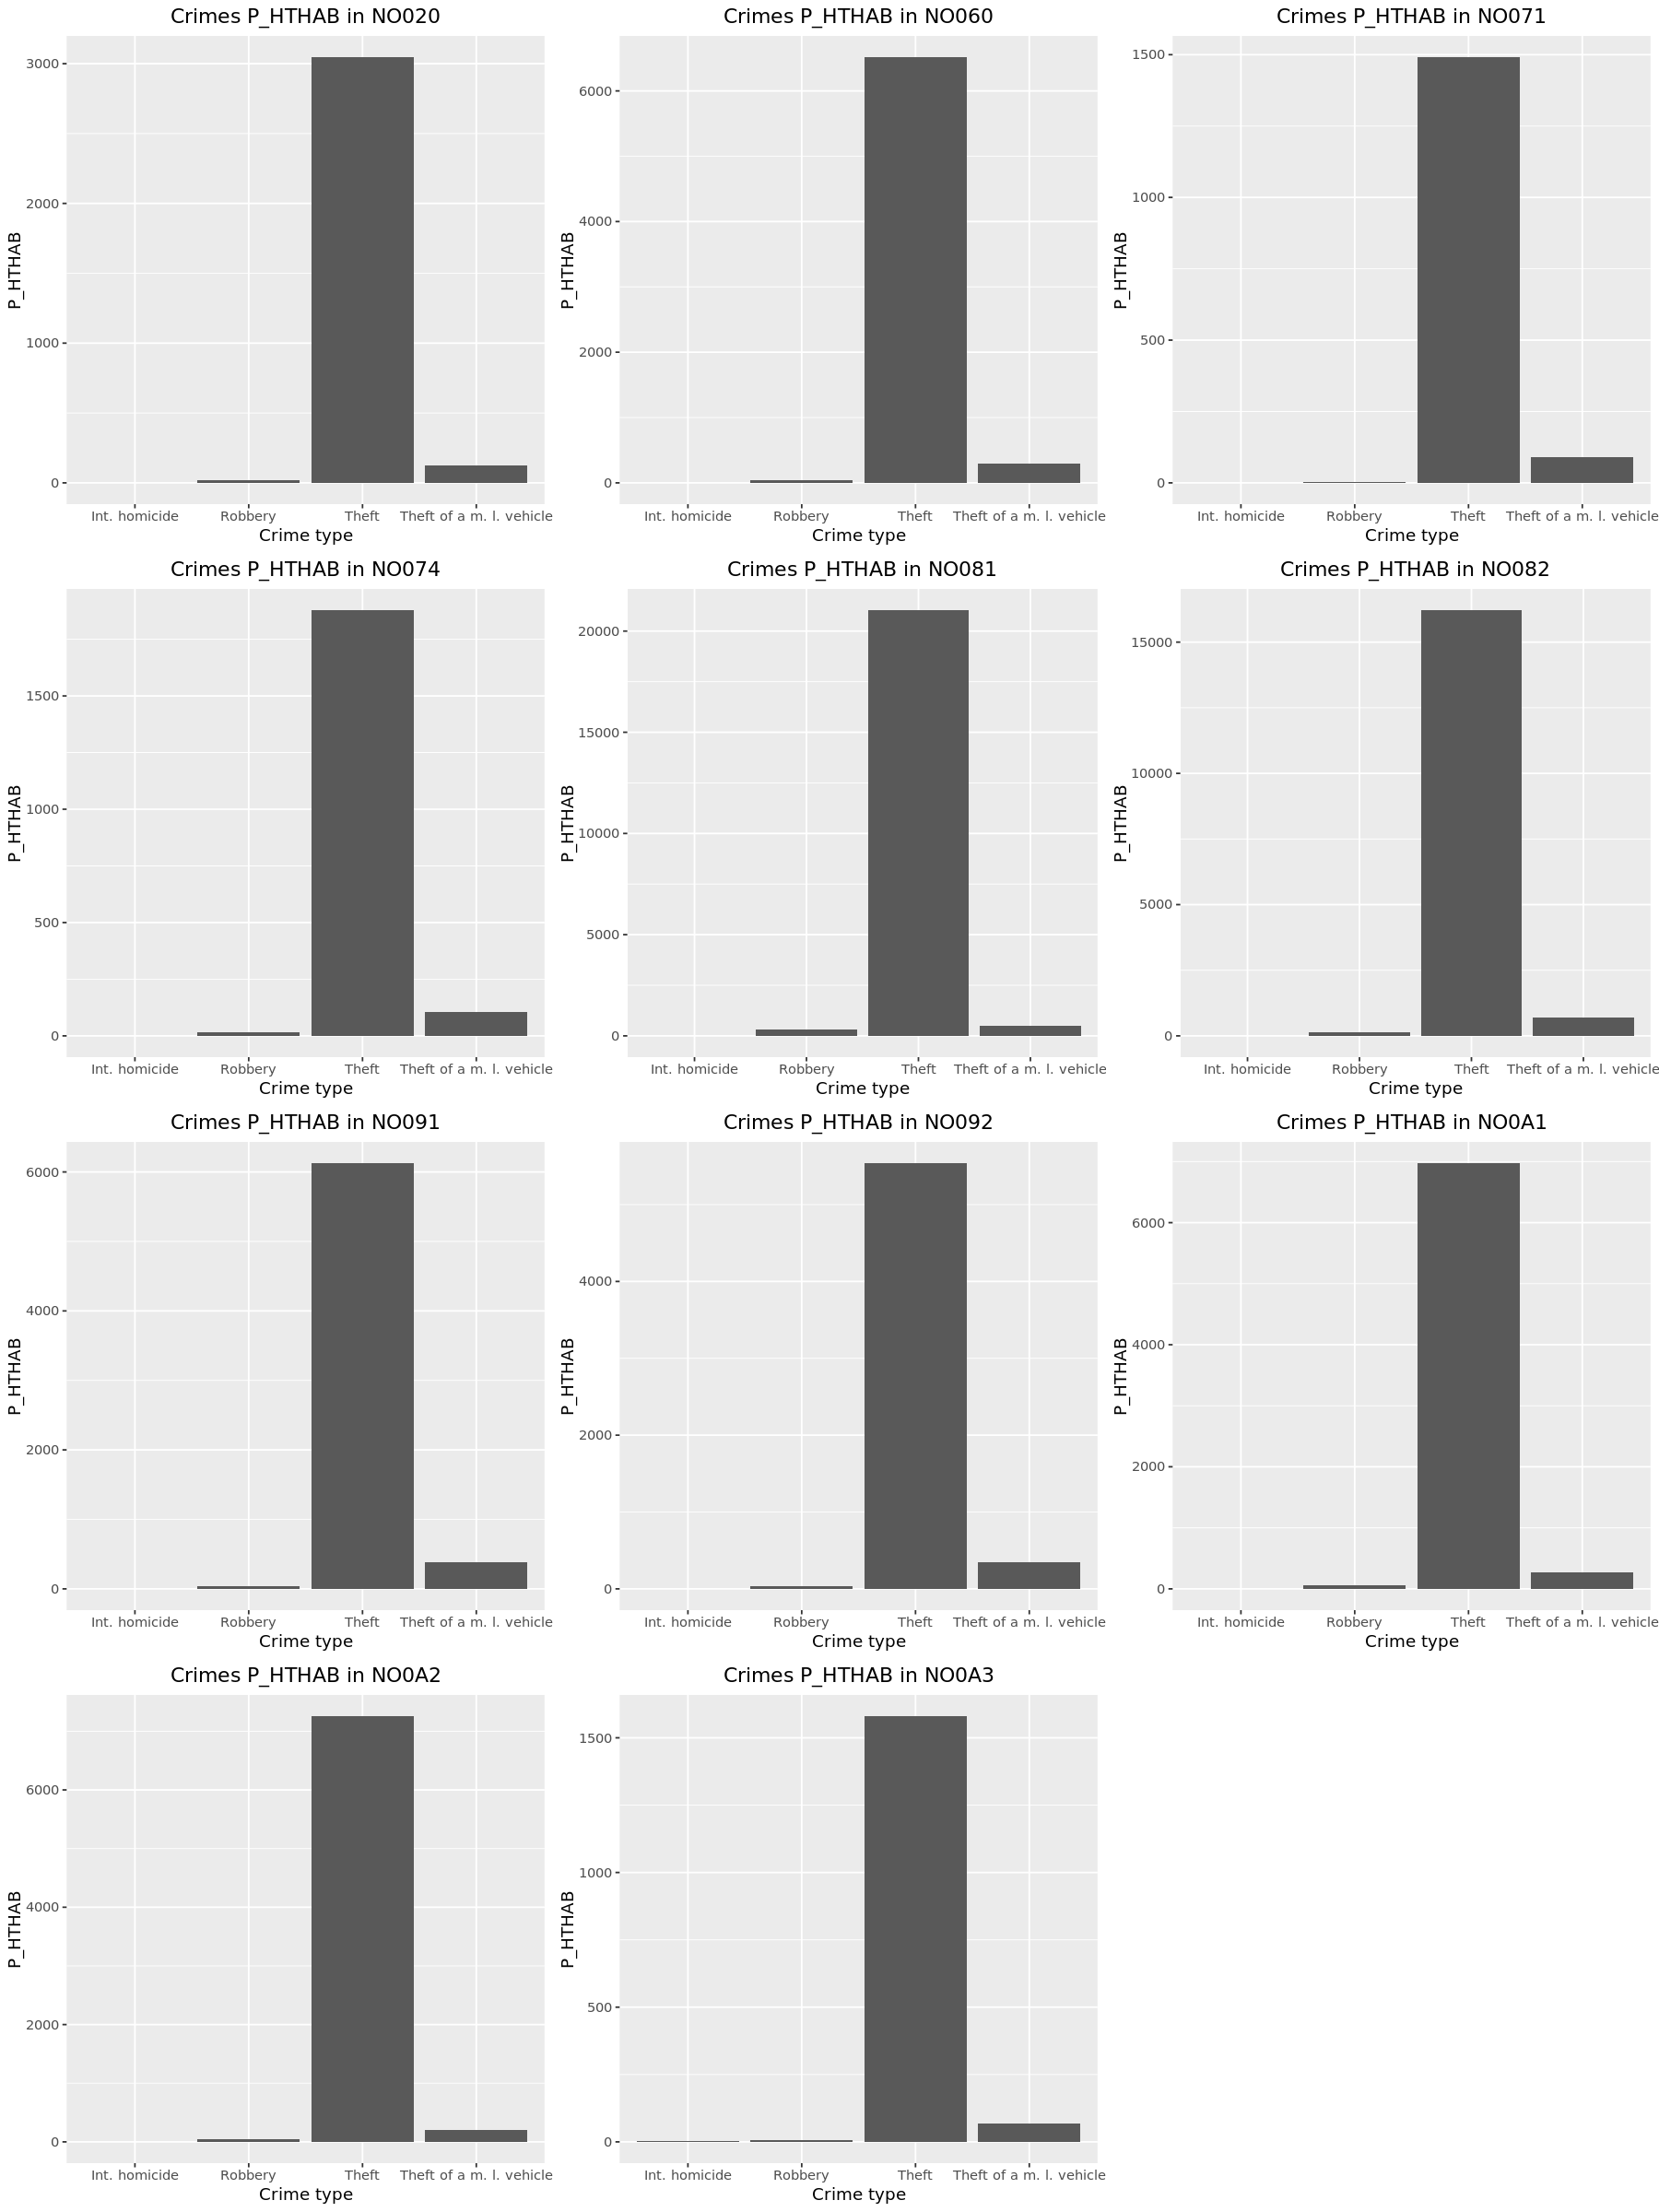

In [9]:
# Prepare a function which plots a bar plot for each region
region_bar_plot <- function(region){
    # Select data by the region
    data_region <- data.a[data.a$geo == region,]
    # Make a single bar plot
    plot <- ggplot( data = data_region, mapping = aes(x = iccs, y= values)) +
           geom_bar(stat='identity') +   # stat='identity' allows us to use y = values
           labs(title = paste('Crimes P_HTHAB in', region), x = 'Crime type', y = 'P_HTHAB') +
           theme(plot.title = element_text(hjust = 0.5))
    return(plot)
}

plots <- list()
for ( region in norway_nuts3_regions ) {
  # Create the plot
  region_plot <- region_bar_plot(region)
  # Add the plot to the list
  plots <- c(plots, list(region_plot))
}

# regulates the size of a plot [5]
options(repr.plot.width=15, repr.plot.height=20)

final_plot <- plot_grid(plotlist = plots, ncol=3)
final_plot

What we see from the plot upwards is that **without** taking into account the **criminality** of a particular NUTS3 region in Norway,
the **distribution of crimes by types** in all regions is **very similar**. That gives us an **intuition (tests weren't conducted yet)** that
**all crime types** are similarly distributed **in all regions.**

In [10]:
# Get all Norway NUTS3 crime types
norway_crime_types <- unique(data.a$iccs)


 Summary for Int. homicide 
     values      
 Min.   :0.0000  
 1st Qu.:0.0000  
 Median :0.3200  
 Mean   :0.3873  
 3rd Qu.:0.6100  
 Max.   :1.0400  
 Var. 0.1582618 

 Summary for Robbery 
     values      
 Min.   : 1.660  
 1st Qu.: 5.455  
 Median : 8.910  
 Mean   :11.282  
 3rd Qu.:10.930  
 Max.   :46.910  
 Var. 152.6481 

 Summary for Theft 
     values      
 Min.   : 595.0  
 1st Qu.: 798.7  
 Median :1294.7  
 Mean   :1303.0  
 3rd Qu.:1448.3  
 Max.   :3017.2  
 Var. 473223.5 

 Summary for Theft of a m. l. vehicle 
     values      
 Min.   : 25.23  
 1st Qu.: 34.98  
 Median : 54.62  
 Mean   : 56.57  
 3rd Qu.: 68.36  
 Max.   :112.35  
 Var. 740.4944 


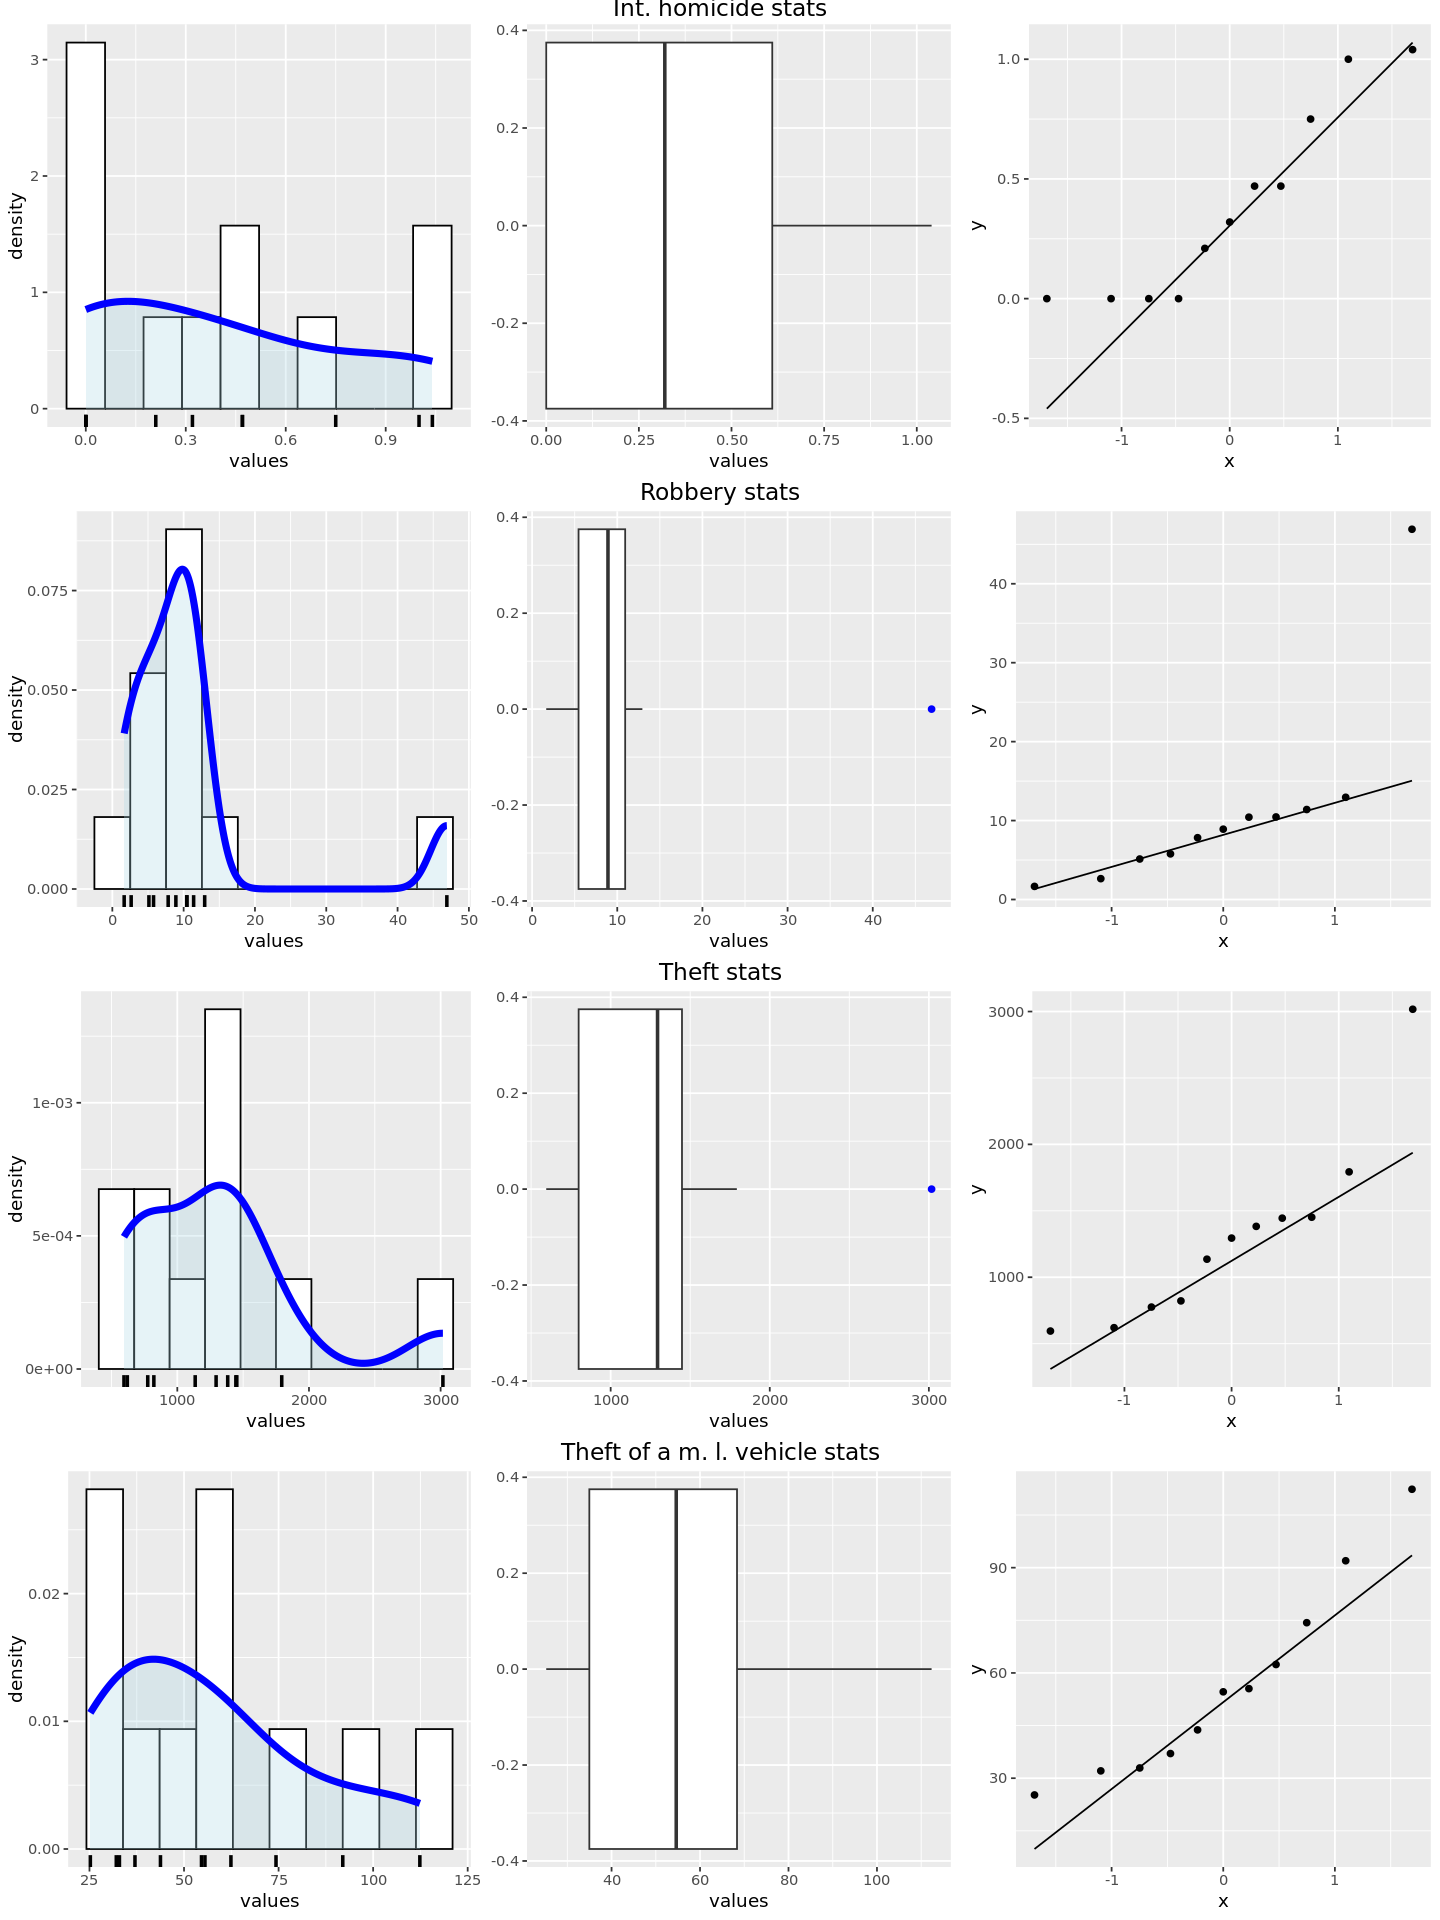

In [35]:
# Prepare a function for conducting descriptive statistics for all types of crime
crimetype_desc_stats <- function(iccs_given) {
    # Here relative relative values are used so we won't take the population of regions into account
    iccs_data <- subset(data.r, iccs==iccs_given, select=-c(iccs, geo))
    # Summary about values of a particular crime type
    cat('\n', 'Summary for', iccs_given, '\n')
    print(summary(iccs_data))
    cat(' Var.', var(iccs_data), '\n')
    # Prepare a histogram with kde
    hist_kde <- ggplot(iccs_data, aes(x=values)) +
        geom_histogram(aes(y=after_stat(density)), colour = 1, fill = "white", bins=10) + # HISTOGRAM: after_stat(density) - normalization
        geom_density(lwd=2, colour="blue", fill="lightblue", alpha=0.3) +                 # KDE: lwd - libne width
        geom_rug(x=iccs_data$values, colour="black", lwd=1)                               # DATA POINTS
    boxplot <- ggplot(iccs_data, aes(x=values)) +
        geom_boxplot(outlier.color="blue", show.legend=F)
    qqplot <- ggplot(iccs_data, aes(sample=values)) +
        stat_qq(distribution=qnorm, show.legend=F) +
        stat_qq_line(distribution=qnorm, show.legend=F)

    plots <- list(hist_kde, boxplot, qqplot)
    options(repr.plot.width=12, repr.plot.height=4)
    type_plot <- plot_grid(plotlist = plots, ncol=3) +
           labs(title = paste(iccs_given, 'stats')) +
           theme(plot.title = element_text(hjust = 0.5))
    return(type_plot)
}

plots <- list()
for ( crime_type in norway_crime_types ) {
  # Create the plot
  type_plot <- crimetype_desc_stats(crime_type)
  # Add the plot to the list
  plots <- c(plots, list(type_plot))
}

# regulates the size of a plot [5]
options(repr.plot.width=12, repr.plot.height=16)

final_plot <- plot_grid(plotlist = plots, ncol=1)
final_plot

Thanks to visualizations and summaries above, we can see that the **"most popular"** crime in **all** regions is **theft**, the **"least popular"** one is **initial homicide**. What we can say about **variations** is that **theft** and **homicide** have the **biggest and the smallest variations resp.**. From the QQ plot and the histogram we can assume that **the robbery** might have something like **Normal distribution (wasn't tested yet)** but there is this **outlier** which might spoil tests.

## Contingency table

## Hypotheses and tests

## References

1. ***Eurostat, Column description is located in 'About this dataset' section,*** https://ec.europa.eu/eurostat/databrowser/view/crim_gen_reg/default/table?lang=en&category=crim.crim_off
2. ***Eurostat, Dataset metadata (Completeness section)***, https://ec.europa.eu/eurostat/cache/metadata/en/crim_gen_reg_esms.htm
3. ***Eurostat, Dataset metadata (Unit of measure section)***, https://ec.europa.eu/eurostat/cache/metadata/en/crim_gen_reg_esms.htm
4. ***Eurostat, International classification od crime (codes)***, https://ec.europa.eu/eurostat/databrowser/view/crim_gen_reg/default/table?lang=en&category=crim.crim_off
5. ***Revolutions, Regulation of the size of a plot***, https://blog.revolutionanalytics.com/2015/09/resizing-plots-in-the-r-kernel-for-jupyter-notebooks.html
6.  
7.  
8.  
9.  
10.  